In [54]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [55]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [56]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [57]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [58]:
tf.keras.backend.clear_session()

In [59]:
subject = 'Ceará - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [60]:
data = pd.read_csv('2003_mo_model_input_CE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Ceará - Desemprego,Ceará - Consumo de Cimento (t),Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,8.274459,81.265,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,8.268512,65.200,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,8.262564,55.165,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,8.256617,53.928,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,8.250670,65.334,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


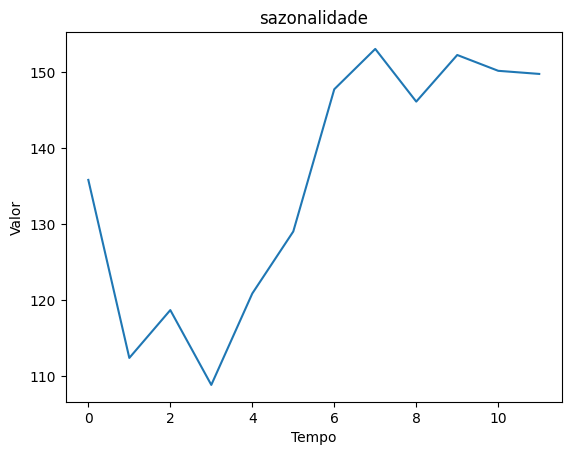

,sazonalidade
sazonalidade,
0,135.794612
1,112.360534
2,118.657694
3,108.808489
4,120.843640
5,129.005874
6,147.725736
7,153.034592
8,146.099918


In [61]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [62]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - IDH,Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - PIB - Per Capita,Ceará - PIB - Preços de Mercado,Ceará - IDH Longevidade,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Ceará - Consumo de Cimento (t)
0,2003-1,8.274459,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,0.684040,6.965352e+07,4.525724e+06,7.532751,6.293821e+07,0.767766,107.673000,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,135.794612,81.265
1,2003-2,8.268512,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,0.684476,6.974354e+07,4.530359e+06,7.535808,6.297178e+07,0.768211,107.237962,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,112.360534,65.200
2,2003-3,8.262564,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,0.684912,6.983356e+07,4.534994e+06,7.538865,6.300536e+07,0.768657,108.742184,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,118.657694,55.165
3,2003-4,8.256617,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,0.685347,6.992358e+07,4.539629e+06,7.541921,6.303893e+07,0.769102,109.391112,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,108.808489,53.928
4,2003-5,8.250670,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,0.685783,7.001361e+07,4.544265e+06,7.544978,6.307250e+07,0.769547,111.602457,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,120.843640,65.334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,35513.477421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.843640,NaN
245,2023-6,NaN,NaN,NaN,NaN,35482.972969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.005874,NaN
246,2023-7,NaN,NaN,NaN,NaN,35420.342200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.725736,NaN
247,2023-8,NaN,NaN,NaN,NaN,35331.884078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.034592,NaN


In [63]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      91.341
1      69.730
2      77.682
3      66.140
4      76.289
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Ceará - Consumo de Cimento (t), Length: 249, dtype: float64

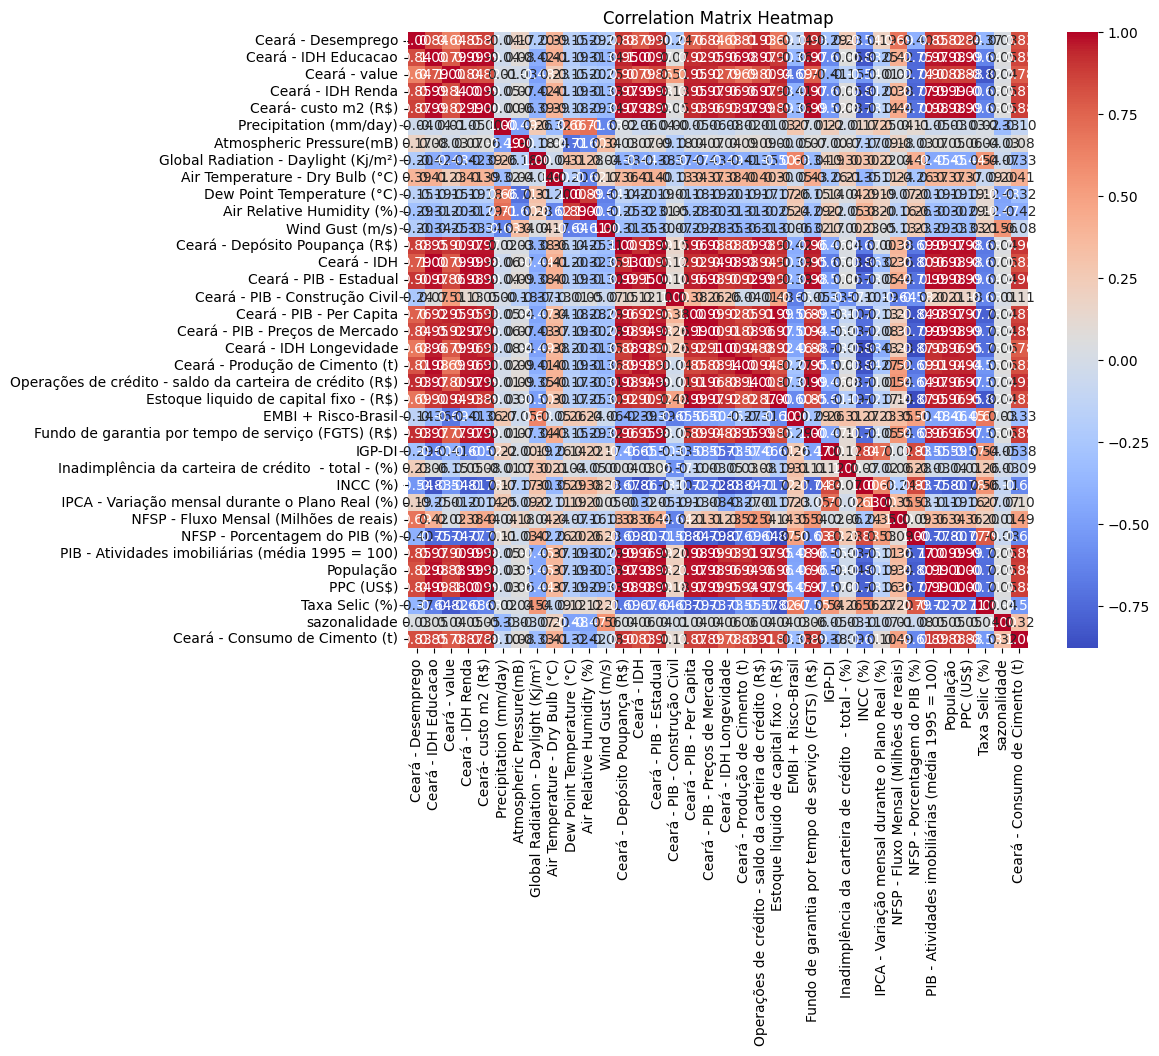

In [64]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [66]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Ceará - Desemprego,1.394561e+05
1,Ceará - IDH Educacao,1.243630e+10
2,Ceará - value,2.942583e+05
3,Ceará - IDH Renda,5.479054e+07
4,Ceará- custo m2 (R$),3.058734e+06
5,Precipitation (mm/day),9.438657e+01
6,Atmospheric Pressure(mB),1.412339e+07
7,Global Radiation - Daylight (Kj/m²),1.405515e+01
8,Air Temperature - Dry Bulb (°C),9.134632e+05
9,Dew Point Temperature (°C),5.054267e+05


In [67]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 4


,Ceará - Desemprego,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,8.274459,0.655921,0.301376,0.609343,10216.279200,1.434011,1009.566955,2194.226625,27.066062,21.474686,72.364001,3.070554,4.636226e+06,6.965352e+07,4.525724e+06,107.673000,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,135.794612
1,8.268512,0.656490,0.301393,0.609740,10302.959969,1.434339,1009.565399,2194.226625,27.066711,21.474876,72.363165,3.069036,4.657223e+06,6.974354e+07,4.530359e+06,107.237962,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,112.360534
2,8.262564,0.657059,0.301309,0.610137,10382.029969,1.434531,1009.564492,2194.226625,27.067090,21.474987,72.362677,3.068150,4.678221e+06,6.983356e+07,4.534994e+06,108.742184,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,118.657694
3,8.256617,0.657627,0.300917,0.610534,10456.629969,1.434551,1009.564395,2194.226625,27.067131,21.474998,72.362625,3.068055,4.699218e+06,6.992358e+07,4.539629e+06,109.391112,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,108.808489
4,8.250670,0.658196,0.300417,0.610931,10527.718245,1.695872,1009.272152,2621.020212,27.009913,21.671734,73.524145,2.951262,4.720215e+06,7.001361e+07,4.544265e+06,111.602457,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,120.843640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,10.636050,0.733639,0.357620,0.661998,24050.984798,1.463095,1010.100153,1376.196952,27.303821,20.518166,67.879887,2.860824,1.042772e+07,8.386519e+07,4.576520e+06,187.438155,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,153.034592
176,10.625073,0.733773,0.359211,0.662042,24135.884866,1.411412,1009.698252,1390.646874,27.483620,20.597239,67.389325,2.959808,1.045929e+07,8.384358e+07,4.576942e+06,187.356403,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,146.099918
177,10.614096,0.733907,0.361147,0.662085,24215.248561,1.297474,1009.208582,1336.013052,27.559584,20.917763,68.312922,2.878837,1.049087e+07,8.382198e+07,4.577364e+06,187.395781,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,152.235477
178,10.603119,0.734041,0.363313,0.662128,24296.339058,1.393748,1008.850070,1229.034302,27.460866,21.247485,70.058513,2.621564,1.052244e+07,8.380037e+07,4.577786e+06,187.375581,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,1.989930e+08,419.430070,1.004174

In [68]:
input_data = data.iloc[:split_index + 1,1:]
# mean = np.mean(input_data, axis=0)
# stddev =  np.std(input_data, axis=0)
# input_data = ((input_data - mean) /stddev)
scaler=MinMaxScaler()
scaled_data = scaler.fit_transform(input_data)
input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.000000,0.110899,0.000000,0.000000,0.371316,0.403687,0.180477,0.384334,0.492771,0.536124,0.765983,0.000000,0.000000,0.000000,0.005362,0.000000,0.000000,0.108706,0.015954,1.000000,0.790380,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.000000,0.807549,0.610185
1,0.007267,0.111104,0.007518,0.006121,0.371437,0.403487,0.180477,0.384609,0.492835,0.536078,0.765283,0.003548,0.006268,0.014215,0.000000,0.000207,0.011007,0.058377,0.005176,0.936603,0.788742,0.968765,0.909144,0.544990,0.965719,0.001689,0.008302,0.003703,0.687691,0.080316
2,0.014534,0.110066,0.015036,0.011704,0.371507,0.403371,0.180477,0.384770,0.492873,0.536051,0.764874,0.007096,0.012535,0.028430,0.018540,0.000221,0.022015,0.100305,0.001016,0.906543,0.788333,0.948151,0.853620,0.532585,0.927412,0.003378,0.016605,0.007525,1.000000,0.222701
3,0.021801,0.105225,0.022553,0.016971,0.371514,0.403359,0.180477,0.384787,0.492877,0.536049,0.764830,0.010644,0.018803,0.042645,0.026539,0.000380,0.033022,0.211591,0.000000,0.858675,0.787696,0.928398,0.828878,0.504220,0.885588,0.005067,0.024907,0.011436,0.616940,0.000000
4,0.029069,0.099059,0.030071,0.021991,0.467057,0.365918,0.215582,0.360507,0.559751,0.599824,0.710931,0.014193,0.025071,0.056860,0.053795,0.000881,0.044030,0.358835,0.002380,0.824839,0.784532,0.970256,0.796137,0.515509,0.838034,0.007149,0.033209,0.015243,0.788236,0.272128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.993146,0.805359,0.996732,0.976871,0.381950,0.471997,0.113194,0.485228,0.167633,0.289914,0.669195,0.978657,0.989470,0.155781,0.988517,0.953376,0.889786,0.201733,0.900757,0.168620,0.816187,0.020697,0.038179,0.496222,0.033352,0.973515,0.986456,0.986889,0.043126,1.000000
176,0.994859,0.824994,0.997549,0.982866,0.363054,0.420508,0.114382,0.561526,0.194511,0.262979,0.714875,0.983992,0.987965,0.157075,0.987509,0.953950,0.885419,0.191748,0.884182,0.176428,0.769775,0.019895,0.016717,0.473326,0.034217,0.980116,0.989842,0.990433,0.169097,0.843200
177,0.996573,0.848900,0.998366,0.988469,0.321397,0.357774,0.109888,0.593762,0.303463,0.313691,0.677508,0.989328,0.986461,0.158368,0.987995,0.956916,0.881053,0.184535,0.927328,0.174368,0.685140,0.020180,0.004270,0.425824,0.035996,0.986717,0.993228,0.993830,0.265091,0.981931
178,0.998286,0.875649,0.999183,0.994195,0.356596,0.311843,0.101089,0.551871,0.415541,0.409536,0.558779,0.994664,0.984957,0.159662,0.987746,0.958509,0.876686,0.179849,0.981078,0.197726,0.619023,0.007298,0.000000,0.448015,0.039184,0.993358,0.996614,0.997134,0.355727,0.934853


In [69]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,0.000000,0.110899,0.000000,0.000000,0.371316,0.403687,0.180477,0.384334,0.492771,0.536124,0.765983,0.000000,0.000000,0.000000,0.005362,0.000000,0.000000,0.108706,0.015954,1.000000,0.790380,1.000000,1.000000,0.543630,1.000000,0.000000,0.000000,0.000000,0.807549,0.610185
1,0.007267,0.111104,0.007518,0.006121,0.371437,0.403487,0.180477,0.384609,0.492835,0.536078,0.765283,0.003548,0.006268,0.014215,0.000000,0.000207,0.011007,0.058377,0.005176,0.936603,0.788742,0.968765,0.909144,0.544990,0.965719,0.001689,0.008302,0.003703,0.687691,0.080316
2,0.014534,0.110066,0.015036,0.011704,0.371507,0.403371,0.180477,0.384770,0.492873,0.536051,0.764874,0.007096,0.012535,0.028430,0.018540,0.000221,0.022015,0.100305,0.001016,0.906543,0.788333,0.948151,0.853620,0.532585,0.927412,0.003378,0.016605,0.007525,1.000000,0.222701
3,0.021801,0.105225,0.022553,0.016971,0.371514,0.403359,0.180477,0.384787,0.492877,0.536049,0.764830,0.010644,0.018803,0.042645,0.026539,0.000380,0.033022,0.211591,0.000000,0.858675,0.787696,0.928398,0.828878,0.504220,0.885588,0.005067,0.024907,0.011436,0.616940,0.000000
4,0.029069,0.099059,0.030071,0.021991,0.467057,0.365918,0.215582,0.360507,0.559751,0.599824,0.710931,0.014193,0.025071,0.056860,0.053795,0.000881,0.044030,0.358835,0.002380,0.824839,0.784532,0.970256,0.796137,0.515509,0.838034,0.007149,0.033209,0.015243,0.788236,0.272128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.970191,0.603422,0.987928,0.902305,0.185712,0.490526,0.120655,0.703184,0.147651,0.162898,0.638037,0.901516,0.995709,0.216071,0.983926,0.973534,0.937006,0.423280,0.849212,0.061396,0.803166,0.094130,0.144755,0.772284,0.015040,0.918734,0.945698,0.938086,0.461869,1.000000
164,0.972383,0.618289,0.988545,0.908227,0.156628,0.424433,0.120598,0.744886,0.200285,0.172014,0.696660,0.909474,0.996567,0.202202,0.988586,0.971665,0.933675,0.387661,0.842872,0.095565,0.850835,0.087555,0.133956,0.741958,0.016631,0.921412,0.949109,0.942492,0.424663,0.843200
165,0.974575,0.635485,0.989162,0.914317,0.200422,0.356475,0.117640,0.752919,0.297907,0.230806,0.686799,0.917432,0.997426,0.188333,0.995051,0.970441,0.930344,0.351781,0.895026,0.096417,0.875483,0.083404,0.141095,0.686725,0.018850,0.924089,0.952520,0.946808,0.397941,0.981931
166,0.976767,0.648082,0.989780,0.920645,0.346903,0.316210,0.111801,0.724537,0.424386,0.326614,0.618472,0.925390,0.998284,0.174464,1.000000,0.968444,0.927013,0.319424,0.964451,0.052056,0.869042,0.075773,0.102393,0.792808,0.020846,0.926628,0.955931,0.951146,0.462657,0.934853


In [70]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       91.341
1       69.730
2       77.682
3       66.140
4       76.289
        ...   
163    177.259
164    155.913
165    172.410
166    179.419
167    157.165
Name: Ceará - Consumo de Cimento (t), Length: 168, dtype: float64

In [71]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [72]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 30)

In [73]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Ceará - IDH Educacao,Ceará - value,Ceará - IDH Renda,Ceará- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Ceará - Depósito Poupança (R$),Ceará - PIB - Estadual,Ceará - PIB - Construção Civil,Ceará - Produção de Cimento (t),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,0.701478,0.998034,0.788555,0.697074,0.430073,0.283169,0.100066,0.536152,0.838109,0.669130,0.519822,0.979753,0.912099,0.708921,0.579764,0.824957,1.000000,0.116855,0.767559,0.297841,0.063050,0.368307,0.710818,0.600233,0.076793,0.912582,0.834889,0.820470,0.230530,0.610185
133,0.704301,0.995668,0.787898,0.703233,0.529601,0.276388,0.092468,0.469566,0.808820,0.686451,0.383465,0.973048,0.915859,0.695822,0.590034,0.832587,0.999030,0.128078,0.728075,0.310249,0.064498,0.356043,0.737933,0.683286,0.080065,0.914530,0.838610,0.823328,0.254634,0.080316
134,0.707124,0.993189,0.787241,0.709253,0.642303,0.317802,0.089832,0.439789,0.777730,0.679211,0.326095,0.966343,0.919618,0.682724,0.606009,0.840712,0.998060,0.131464,0.716376,0.298259,0.087497,0.365871,0.731922,0.691333,0.083086,0.916477,0.842332,0.826215,0.336791,0.222701
135,0.709948,0.988080,0.786583,0.715307,0.673291,0.392467,0.088521,0.379318,0.653770,0.627603,0.328432,0.959638,0.923377,0.669626,0.622323,0.849002,0.997090,0.133803,0.712712,0.264133,0.096187,0.374560,0.722500,0.683763,0.085709,0.918425,0.846053,0.829052,0.183003,0.000000
136,0.712771,0.981506,0.785926,0.721394,0.598381,0.459804,0.092867,0.358622,0.337033,0.456091,0.427374,0.952933,0.927136,0.656528,0.639054,0.856512,0.996121,0.134128,0.716291,0.283400,0.110126,0.347016,0.735417,0.750790,0.089485,0.919796,0.849774,0.831800,0.160974,0.272128
137,0.715594,0.968452,0.785269,0.728645,0.495997,0.523842,0.100047,0.371309,0.274212,0.407369,0.562785,0.946228,0.930896,0.643430,0.656025,0.863910,0.995151,0.136063,0.719365,0.345980,0.110851,0.340984,0.736663,0.748426,0.091963,0.921167,0.853496,0.834534,0.205407,0.456685
138,0.718418,0.947417,0.784612,0.735968,0.374727,0.547288,0.106555,0.394608,0.134405,0.305359,0.687968,0.939523,0.934655,0.630332,0.673354,0.872003,0.994181,0.140590,0.727261,0.355524,0.115684,0.333970,0.750484,0.765274,0.093682,0.922539,0.857217,0.836982,0.250543,0.879961
139,0.721241,0.924448,0.783955,0.742577,0.253554,0.505357,0.111747,0.452687,0.077001,0.237088,0.779065,0.932818,0.938414,0.617234,0.691037,0.881396,0.993211,0.145335,0.733285,0.388252,0.116796,0.316991,0.781650,0.799973,0.094876,0.922662,0.860938,0.839358,0.302580,1.000000
140,0.724064,0.901748,0.783298,0.749266,0.267846,0.467218,0.114430,0.510499,0.124695,0.232897,0.821837,0.926113,0.942174,0.604136,0.709145,0.891920,0.992241,0.149790,0.736810,0.392252,0.093280,0.324046,0.780630,0.803815,0.095765,0.922785,0.864660,0.841836,0.229929,0.843200
141,0.726888,0.885016,0.782640,0.755864,0.345908,0.436583,0.115572,0.544027,0.155634,0.234039,0.817591,0.919408,0.945933,0.591038,0.727666,0.904492,0.991271,0.156217,0.787147,0.401389,0.054593,0.324890,0.771685,0.692895,0.095412,0.922908,0.868381,0.844376,0.334488,0.981931


In [74]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [75]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [76]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [77]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [78]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [79]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2431845908, 1417276942, 309820066, 1406083494, 2240700730, 3231643321, 2723389280, 789952242, 4259385630, 3268129094]


Step: 0 ___________________________________________
val_loss: 171.97967529296875
winner_seed: 2431845908


Step: 1 ___________________________________________
val_loss: 170.73858642578125
winner_seed: 1417276942


Step: 2 ___________________________________________
val_loss: 122.38728332519531
winner_seed: 309820066


Step: 3 ___________________________________________
val_loss: 157.2145233154297


Step: 4 ___________________________________________
val_loss: 227.96115112304688


Step: 5 ___________________________________________
val_loss: 481.11553955078125


Step: 6 ___________________________________________
val_loss: 267.38275146484375


Step: 7 ___________________________________________
val_loss: 277.87359619140625


Step: 8 ___________________________________________
val_loss: 143.19403076171875


Step: 9 ___________________________________________
val_loss: 

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,118.599335,109.161179,110.017975,109.849953,118.314644,122.76873,158.316467,160.264313,156.562561,160.944763,159.028885,129.149094
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,33.001663,20.375824,4.781975,0.985046,9.610359,4.36927,1.188461,4.17569,16.264557,7.462234,4.586121,25.920914


[2735149201, 3497898203, 75539775, 2030184366, 3677983152, 2152005459, 4041105816, 4259799436, 2701788291, 2243557730]


Step: 0 ___________________________________________
val_loss: 145.90023803710938
winner_seed: 2735149201


Step: 1 ___________________________________________
val_loss: 282.0391845703125


Step: 2 ___________________________________________
val_loss: 610.6309204101562


Step: 3 ___________________________________________
val_loss: 219.1675262451172


Step: 4 ___________________________________________
val_loss: 392.61663818359375


Step: 5 ___________________________________________
val_loss: 92.37393951416016
winner_seed: 2152005459


Step: 6 ___________________________________________
val_loss: 431.74896240234375


Step: 7 ___________________________________________
val_loss: 70.33777618408203
winner_seed: 4259799436


Step: 8 ___________________________________________
val_loss: 193.44598388671875


Step: 9 ___________________________________________
val_loss: 183

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,129.169922,115.719658,116.126732,115.536354,116.586998,121.548058,176.655548,195.896042,183.393494,198.389343,192.498474,178.475479
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,22.431076,13.817345,10.890732,4.701355,11.338005,5.589943,19.527542,31.456039,43.09549,29.982346,28.883469,23.405472


[2203100818, 796861796, 1468274391, 3819701574, 388659127, 823147976, 4210885286, 4251461483, 2007416540, 994265207]


Step: 0 ___________________________________________
val_loss: 153.0387420654297
winner_seed: 2203100818


Step: 1 ___________________________________________
val_loss: 169.51116943359375


Step: 2 ___________________________________________
val_loss: 672.3198852539062


Step: 3 ___________________________________________
val_loss: 128.55569458007812
winner_seed: 3819701574


Step: 4 ___________________________________________
val_loss: 376.0964050292969


Step: 5 ___________________________________________
val_loss: 153.8507537841797


Step: 6 ___________________________________________
val_loss: 296.7474365234375


Step: 7 ___________________________________________
val_loss: 231.13064575195312


Step: 8 ___________________________________________
val_loss: 695.565673828125


Step: 9 ___________________________________________
val_loss: 144.57955932617188
1/1 [=======

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,144.582092,121.819901,123.169205,121.646126,126.51207,140.471313,172.010025,173.212265,170.163651,172.381882,170.295639,165.925354
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,7.018906,7.717102,17.933205,10.811127,1.412933,13.333313,14.882019,8.772263,29.865646,3.974884,6.680634,10.855347


[3811306071, 3562730281, 775958274, 1273626521, 1872883149, 4022340086, 2728619959, 2837695686, 2276794698, 1748756656]


Step: 0 ___________________________________________
val_loss: 123.43880462646484
winner_seed: 3811306071


Step: 1 ___________________________________________
val_loss: 244.54269409179688


Step: 2 ___________________________________________
val_loss: 118.77418518066406
winner_seed: 775958274


Step: 3 ___________________________________________
val_loss: 225.14193725585938


Step: 4 ___________________________________________
val_loss: 216.38290405273438


Step: 5 ___________________________________________
val_loss: 193.29635620117188


Step: 6 ___________________________________________
val_loss: 299.9769592285156


Step: 7 ___________________________________________
val_loss: 123.61274719238281


Step: 8 ___________________________________________
val_loss: 246.53076171875


Step: 9 ___________________________________________
val_loss: 174.438232421875
1/1 [====

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,136.959717,115.131798,115.147171,115.194664,115.9049,144.801697,178.82074,190.466888,195.203156,204.304474,189.13739,168.107071
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,14.641281,14.405205,9.911171,4.359665,12.020103,17.663696,21.692734,26.026886,54.905151,35.897476,25.522385,13.037064


[1844710771, 3530382054, 1582577797, 1515029791, 1284323483, 69968983, 2077617853, 110088562, 2647366419, 1693869788]


Step: 0 ___________________________________________
val_loss: 267.0077819824219
winner_seed: 1844710771


Step: 1 ___________________________________________
val_loss: 124.78343200683594
winner_seed: 3530382054


Step: 2 ___________________________________________
val_loss: 656.1882934570312


Step: 3 ___________________________________________
val_loss: 208.1504364013672


Step: 4 ___________________________________________
val_loss: 117.7096939086914
winner_seed: 1284323483


Step: 5 ___________________________________________
val_loss: 409.32275390625


Step: 6 ___________________________________________
val_loss: 301.38519287109375


Step: 7 ___________________________________________
val_loss: 267.74755859375


Step: 8 ___________________________________________
val_loss: 107.2208023071289
winner_seed: 2647366419


Step: 9 ________________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,139.231186,114.944122,117.505875,113.905724,117.694832,138.777084,166.682541,179.057785,186.879395,186.350662,175.615219,165.66571
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,12.369812,14.59288,12.269875,3.070724,10.230171,11.639084,9.554535,14.617783,46.58139,17.943665,12.000214,10.595703


[2662308684, 1089426583, 2217583851, 3089673987, 4100213406, 3710377296, 2559700888, 3587074548, 2428729289, 1920871586]


Step: 0 ___________________________________________
val_loss: 148.11642456054688
winner_seed: 2662308684


Step: 1 ___________________________________________
val_loss: 145.20602416992188
winner_seed: 1089426583


Step: 2 ___________________________________________
val_loss: 241.1769561767578


Step: 3 ___________________________________________
val_loss: 129.75338745117188
winner_seed: 3089673987


Step: 4 ___________________________________________
val_loss: 127.17059326171875
winner_seed: 4100213406


Step: 5 ___________________________________________
val_loss: 145.6165771484375


Step: 6 ___________________________________________
val_loss: 422.8223571777344


Step: 7 ___________________________________________
val_loss: 124.38938903808594
winner_seed: 3587074548


Step: 8 ___________________________________________
val_loss: 216.48263549804688


Step: 9 _____

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,142.174042,129.612534,133.960358,137.059052,142.342178,164.518616,181.318604,191.560959,183.410538,194.553635,189.555679,184.503113
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,9.426956,0.075531,28.724358,26.224052,14.417175,37.380615,24.190598,27.120956,43.112534,26.146637,25.940674,29.433105


[1078076881, 2833577084, 814831108, 2272975838, 3287170806, 1714895583, 866438309, 2931321988, 1488142178, 1850630998]


Step: 0 ___________________________________________
val_loss: 211.1560516357422
winner_seed: 1078076881


Step: 1 ___________________________________________
val_loss: 208.4475555419922
winner_seed: 2833577084


Step: 2 ___________________________________________
val_loss: 283.6759338378906


Step: 3 ___________________________________________
val_loss: 135.28756713867188
winner_seed: 2272975838


Step: 4 ___________________________________________
val_loss: 309.8546142578125


Step: 5 ___________________________________________
val_loss: 204.4825897216797


Step: 6 ___________________________________________
val_loss: 176.46417236328125


Step: 7 ___________________________________________
val_loss: 131.00201416015625
winner_seed: 2931321988


Step: 8 ___________________________________________
val_loss: 312.3371887207031


Step: 9 __________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,143.237457,120.578819,124.777054,120.321625,124.209213,152.331268,174.106491,184.469727,185.69487,188.161499,183.400024,171.567001
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,8.363541,8.958183,19.541054,9.486626,3.71579,25.193268,16.978485,20.029724,45.396866,19.754501,19.785019,16.496994


[442163637, 2141040057, 3978218654, 977654745, 3496207264, 1672750838, 1115139155, 982399063, 348197079, 2075045147]


Step: 0 ___________________________________________
val_loss: 307.9890441894531
winner_seed: 442163637


Step: 1 ___________________________________________
val_loss: 238.4267120361328
winner_seed: 2141040057


Step: 2 ___________________________________________
val_loss: 516.2213745117188


Step: 3 ___________________________________________
val_loss: 723.8302001953125


Step: 4 ___________________________________________
val_loss: 110.6966323852539
winner_seed: 3496207264


Step: 5 ___________________________________________
val_loss: 102.37274932861328
winner_seed: 1672750838


Step: 6 ___________________________________________
val_loss: 548.0078125


Step: 7 ___________________________________________
val_loss: 239.4408416748047


Step: 8 ___________________________________________
val_loss: 259.8670349121094


Step: 9 ___________________________________________
v

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,117.213196,116.650848,116.46714,116.488945,116.63353,123.56636,162.133423,166.896133,158.999207,164.941833,156.064117,142.629822
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,34.387802,12.886154,11.23114,5.653946,11.291473,3.57164,5.005417,2.456131,18.701202,3.465164,7.550888,12.440186


[1198311013, 2823441533, 489267303, 219305281, 2379890327, 3106356765, 1783444241, 871283357, 929608755, 1425839457]


Step: 0 ___________________________________________
val_loss: 141.62542724609375
winner_seed: 1198311013


Step: 1 ___________________________________________
val_loss: 424.087890625


Step: 2 ___________________________________________
val_loss: 156.24664306640625


Step: 3 ___________________________________________
val_loss: 626.5925903320312


Step: 4 ___________________________________________
val_loss: 178.3601531982422


Step: 5 ___________________________________________
val_loss: 156.16397094726562


Step: 6 ___________________________________________
val_loss: 400.2240905761719


Step: 7 ___________________________________________
val_loss: 180.16851806640625


Step: 8 ___________________________________________
val_loss: 155.1268310546875


Step: 9 ___________________________________________
val_loss: 127.60786437988281
winner_seed: 1425839457
1/1 [=========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,132.685287,117.618614,118.367653,116.876312,118.211815,129.72963,151.984375,176.206055,155.777039,187.413269,184.343796,181.717697
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,18.91571,11.918388,13.131653,6.041313,9.713188,2.591629,5.143631,11.766052,15.479034,19.006271,20.72879,26.64769


[105142040, 4201870301, 99816311, 1519001855, 2625693384, 432200800, 3973566188, 1914874622, 70684726, 422249635]


Step: 0 ___________________________________________
val_loss: 127.7215576171875
winner_seed: 105142040


Step: 1 ___________________________________________
val_loss: 331.2537841796875


Step: 2 ___________________________________________
val_loss: 194.9852752685547


Step: 3 ___________________________________________
val_loss: 165.33847045898438


Step: 4 ___________________________________________
val_loss: 155.49371337890625


Step: 5 ___________________________________________
val_loss: 217.4269256591797


Step: 6 ___________________________________________
val_loss: 512.0588989257812


Step: 7 ___________________________________________
val_loss: 107.81832122802734
winner_seed: 1914874622


Step: 8 ___________________________________________
val_loss: 88.79310607910156
winner_seed: 70684726


Step: 9 ___________________________________________
val_loss: 148.20549011

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,143.684769,127.090057,130.863861,127.271751,133.153381,138.856247,152.755692,161.442322,150.605698,162.31311,154.172501,147.8396
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,7.916229,2.446945,25.627861,16.436752,5.228378,11.718246,4.372314,2.997681,10.307693,6.093887,9.442505,7.230408


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,134.753708,118.832764,120.640297,119.415054,122.956345,137.736908,167.478394,177.947235,172.668976,181.975449,175.411163,163.557999
Target,151.601,129.537,105.236,110.835,127.925,127.138,157.128,164.44,140.298,168.407,163.615,155.07
Error,16.847292,10.704236,15.404297,8.580054,4.968655,10.598908,10.350394,13.507235,32.370976,13.568449,11.796163,8.487999


In [80]:
display(mae)
display(mape)

149.44786

0.09382560760667762